# Importing libraries
Just importing some libraries. Also, before you try to run this notebook, make sure the dataset is on the same folder!

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os 

import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np

import scipy

import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

# Data split, augmentation and loaders
Now we're going to visualize the data and define the loaders! Since we only have a training and test set, we're gonna split the latter on testing and validation set. We're also going to apply transforms to the data so better train the model!

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

imageXY = 128

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.Resize(imageXY),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(24),
                               transforms.ToTensor(),
                               transforms.Normalize(mean = mean, std = std)])

# choose the training and test datasets
total_data =  datasets.ImageFolder('staticmap', transform=transform)

num_workers = 0
batch_size = 64
valid_size = 0.5      # percentage of training set to use as validation


# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.Resize(imageXY),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean, std = std)])

# choose the training and test datasets
train_data =  datasets.ImageFolder('staticmap/train', transform=transform)
test_data =  datasets.ImageFolder('staticmap/test', transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


# specify the image classes
classes = ["industrial", "residential"]


# Data visualization

In [3]:
# helper function to un-normalize and display an image
def imshow(img):
    for idx, channel in enumerate(img):   # we use a custom 'mean' and 'std'. Therefore, we need to loop through each channel and unnormalize properly
        img[idx] = ((img[idx] * std[idx]) + mean[idx])
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

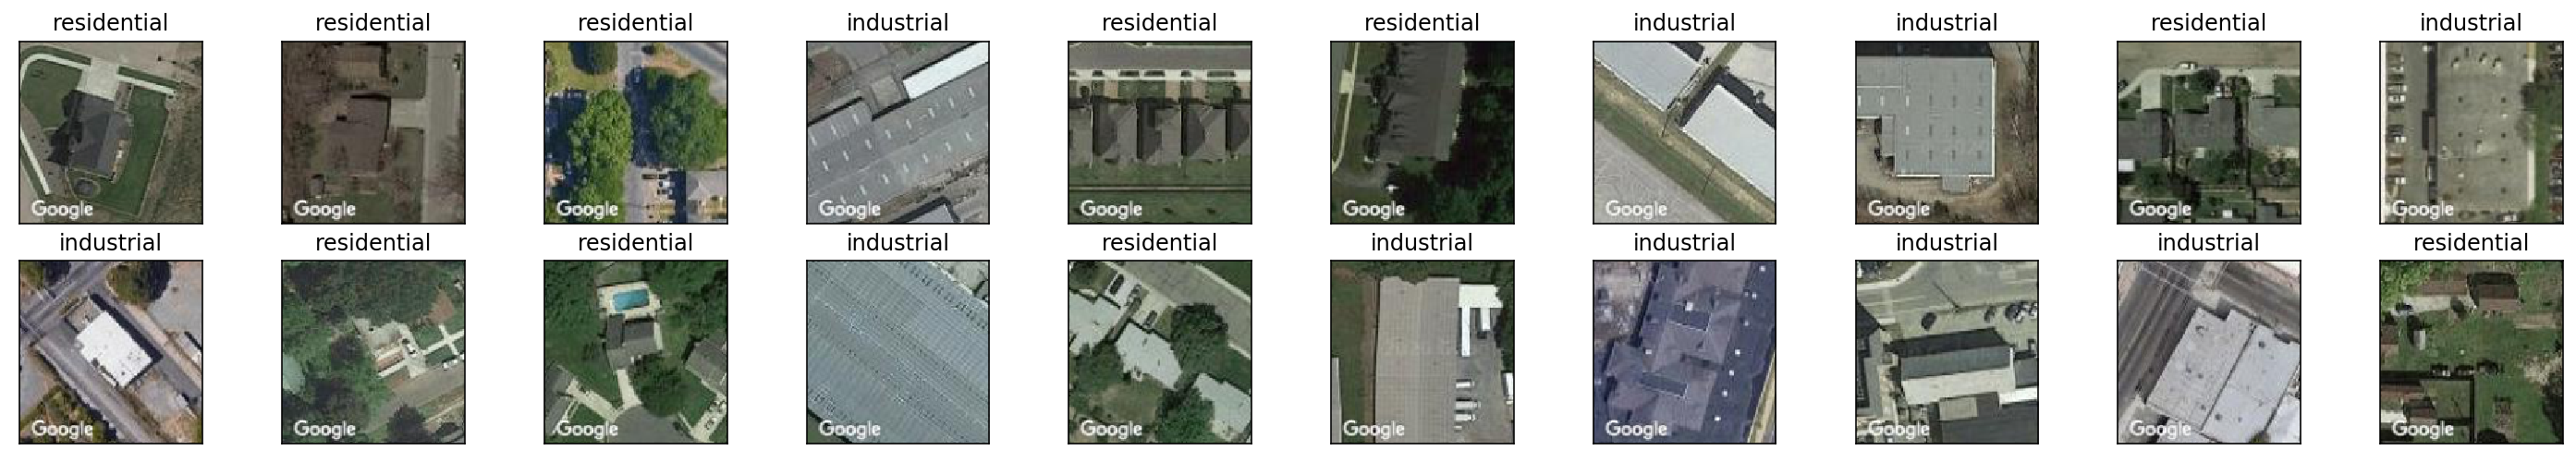

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Model Architecture

CNNs are extremely useful and have shown tremendous success in image classification tarks. In this case, we're defining a CNN architecture by subclassing ```nn.Module```. At its most basic, a CNN architecture will be composed of a counterpart that is tasked with feature-detection (composed of 2D convolutional layers and pooling layers) and another that is composed of fully connected layers. These are, respectivelly, called **features** and **classifier**.

For this case, we're going to do simple five convolutional layers with max pooling, followed by four fully connected layers. For all of these layers, we're using the ReLu activation function to add non-linearities to the model!

Do notice how in each convolutional layer, we're using a kernel size of 3 and a padding of 1, to preserve the image.

![CNN_Arquitecture](images/cnn.png)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
class RvIModel(nn.Module):
    def __init__(self):
        super(RvIModel, self).__init__()
        # convolutional layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),   #128x128x3 image tensor
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1),   #64x64x16 image tensor
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),    #32x32x32 image tensor
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),    #16x16x64 image tensor
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),    #8x8x128 image tensor
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
                                                    #4x4x256 image tensor
                                               
        )      
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),         # we're multiplying the image tensor dimensions, the output of the feature part
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 64), 
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(64, 2), 
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        
        x = x.view(-1, 256 * 4 * 4)      # flattening features for fully connected layers
        
        x = self.classifier(x)
        
        return x
    
model = RvIModel()

## Defining loss function and optimizer

To train the model, we ought to define a loss function. Since the model is outputing through a `nn.LogSoftmax` function, we need to use the negative log likelihood loss in order to obtain the same result if we were to use the cross-entropy method applied to raw outputs. Therefore, NNLoss it goes!

In [40]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

model.to(device)

RvIModel(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=102

# Train the model

We're going to train the model now. We'll have a validation loop to track if we're overfitting or not.

In [41]:
# Name of the model export
name_model = "RvI_classifier_model.pt"

# Number of epochs to train the model
n_epochs = 20

# Track change in validation loss
valid_loss_min = np.Inf 

train_losses_array, validation_losses_array = [], []
for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    # TRAINING THE MODEL
    model.train()
    for data, target in train_loader:
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    # VALIDATION
    model.eval()
    for data, target in valid_loader:

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)
    
    # Calculating the average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Adding losses to array to plot later
    train_losses_array.append(train_loss/len(train_loader))
    validation_losses_array.append(valid_loss/len(valid_loader))
        
    # Printing training/validation information per epoch 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Saving model if validation loss has decreased from last iteration
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), name_model)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.673240 	Validation Loss: 0.575559
Validation loss decreased (inf --> 0.575559).  Saving model ...
Epoch: 2 	Training Loss: 0.521435 	Validation Loss: 0.481173
Validation loss decreased (0.575559 --> 0.481173).  Saving model ...
Epoch: 3 	Training Loss: 0.497779 	Validation Loss: 0.438396
Validation loss decreased (0.481173 --> 0.438396).  Saving model ...
Epoch: 4 	Training Loss: 0.456656 	Validation Loss: 0.421745
Validation loss decreased (0.438396 --> 0.421745).  Saving model ...
Epoch: 5 	Training Loss: 0.445363 	Validation Loss: 0.440169
Epoch: 6 	Training Loss: 0.441125 	Validation Loss: 0.416975
Validation loss decreased (0.421745 --> 0.416975).  Saving model ...
Epoch: 7 	Training Loss: 0.420346 	Validation Loss: 0.427811
Epoch: 8 	Training Loss: 0.422903 	Validation Loss: 0.408252
Validation loss decreased (0.416975 --> 0.408252).  Saving model ...
Epoch: 9 	Training Loss: 0.406481 	Validation Loss: 0.410297
Epoch: 10 	Training Loss: 0.417881 	Valida

In [42]:
model.load_state_dict(torch.load(name_model))

<All keys matched successfully>

# Testing the accuracy

Now we'll use the testing dataset to test the accuracy of our trained model.

In [43]:
# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    # Convert output probabilities to predicted class
    _, prediction = torch.max(output, 1)    
    
    # Compare predictions to true label
    correct_tensor = prediction.eq(target.data.view_as(prediction))
    
    # Convert the output into a numpy array
    if device == 'cuda': 
        correct = np.squeeze(correct_tensor.numpy())
    else:
        correct = np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.227522

Test Accuracy of industrial: 90% (136/150)
Test Accuracy of residential: 92% (139/150)

Test Accuracy (Overall): 91% (275/300)


# Output visualization

Visualizing the training and validating loss and check if we're overfitting the model or not. We need to reach the sweet spot where both training loss and validation loss have met. If they've yet to do so, we can try to increase the learning rate, tinker with data augmentation and hyperparameters.



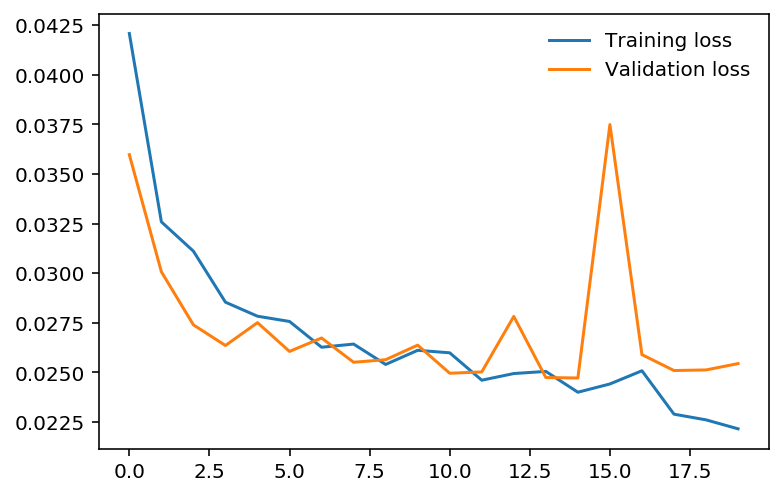

In [44]:
plt.plot(train_losses_array, label='Training loss')
plt.plot(validation_losses_array, label='Validation loss')
plt.legend(frameon=False)

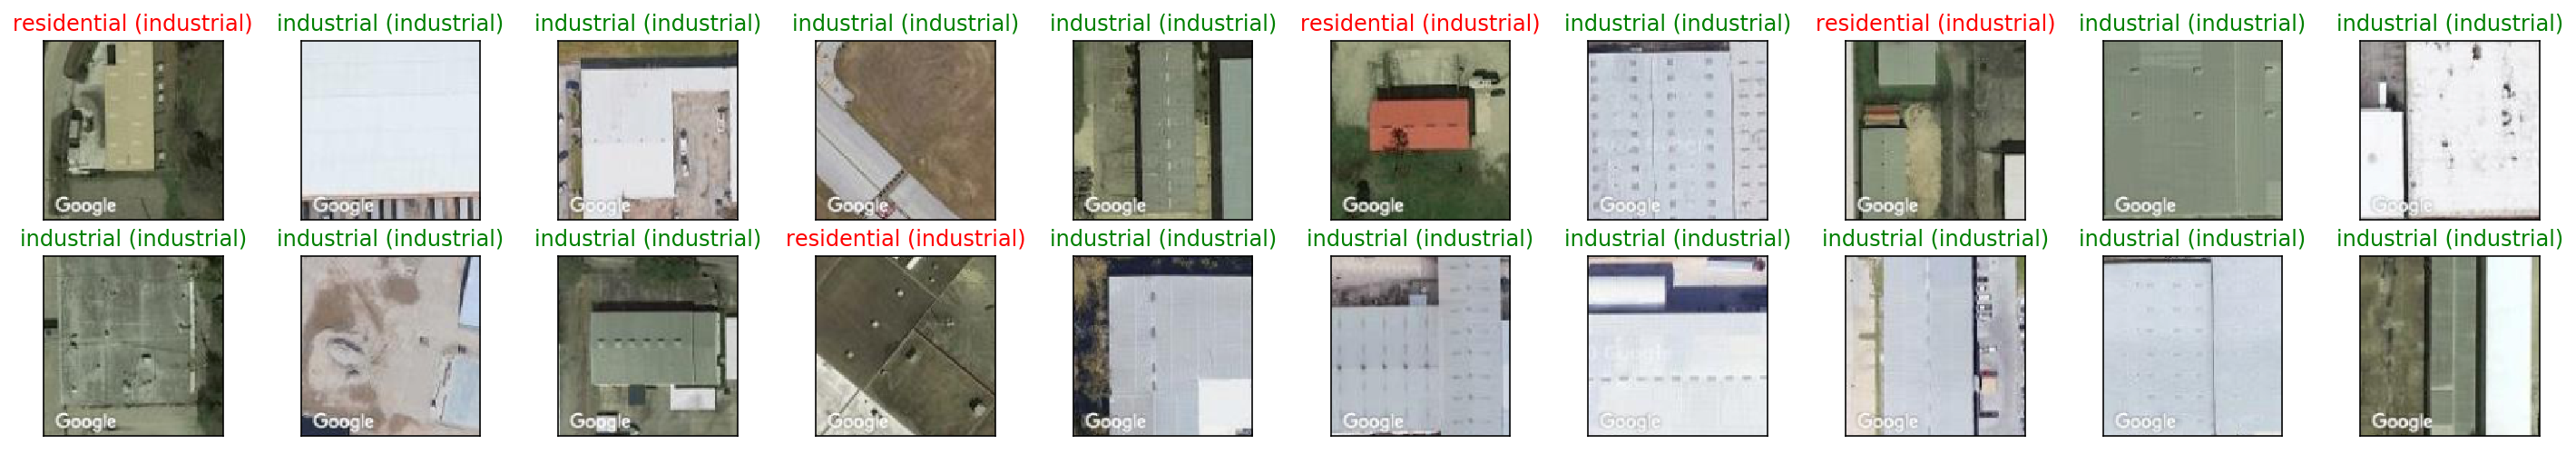

In [49]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)

if device == "cuda":
    preds = np.squeeze(preds_tensor.numpy()) 
else:
    preds = np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))